In today's post we will take a look at the NLP classification task.  One of the simpler algorithms is Bag-Of-Words. Each word is one-hot encoded, then the words of a document are averaged and put through the classifier.

As a dataset we are going to use movie reviews which can be downloaded from [Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/data).  A word of disclaimer: the code below is partially based on the sklearn tutorial as well as on very good NLP course [CS224d](http://cs224d.stanford.edu/) from Stanford University

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_curve, auc

In [ ]:
# load data
df = pd.read_csv( 'labeledTrainData.tsv', sep='\t' )

# convert the data
df.insert( 3, 'converted', df.iloc[ :, 2 ].apply( lambda x: BeautifulSoup( x ).get_text() ) )
print( 'available columns: {0}'.format( df.columns ) )

# train test / ratio of 0.66
tt_index = np.random.binomial( 1, 0.66, size=df.shape[0] )
train = df[ tt_index == 1 ]
test = df[ tt_index == 0 ]

In [3]:
vectorizer = TfidfVectorizer( encoding='latin1' )
vectorizer.fit_transform( train.iloc[ :, 3 ] )

<16630x64833 sparse matrix of type '<type 'numpy.float64'>'
	with 2291206 stored elements in Compressed Sparse Row format>

In [4]:
# prepare data
X_train = vectorizer.transform( train.iloc[ :, 3 ] )
y_train = train.iloc[ :, 1 ]
X_test = vectorizer.transform( test.iloc[ :, 3 ] )
y_test = test.iloc[ :, 1 ]

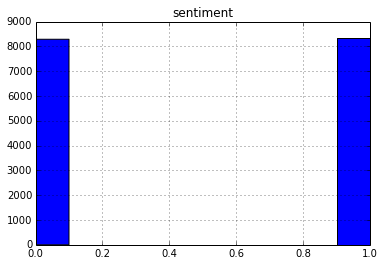

In [5]:
# let's take a look how input classes are distributed.  
# Having more or less equall frequency will help predictor training  
train.hist( column=(1) )
plt.show()

In [6]:
ch2 = SelectKBest(chi2, k=100 )
X_train = ch2.fit_transform( X_train, y_train ).toarray()
X_test = ch2.transform( X_test ).toarray()

In [7]:
# we're going to use Gradient Boosted Tree classifier.  These methods showed good performance on few Kaggle competitions
clf = GradientBoostingClassifier( n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0 )
clf.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=1.0, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=0, subsample=1.0, verbose=0, warm_start=False)

In [8]:
y_score = clf.decision_function( X_test )
fpr, tpr, thresholds = roc_curve( y_test.ravel(), y_score.ravel() )
roc_auc = auc( fpr, tpr )

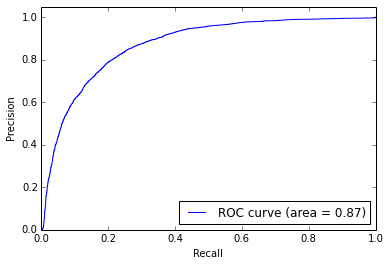

In [11]:
# Plot Precision-Recall curve
plt.clf()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc )
plt.legend(loc="lower right")
plt.show()

AUC of Receiver Operating Characteristic curve shows 0.87 which is a decent margin vs random binary classification.   Given we have two classes: good review or bad review, it make sense to try a linear hyperplane classifier: SVM. 

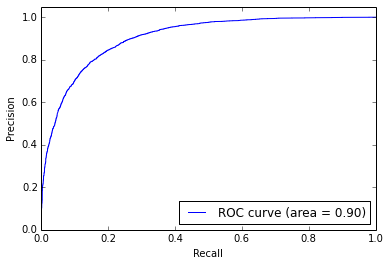

In [13]:
from sklearn.svm import SVC
clf2 = SVC(  kernel='linear' )
clf2.fit( X_train, y_train )

y_score = clf2.decision_function( X_test )
fpr, tpr, thresholds = roc_curve( y_test.ravel(), y_score.ravel() )
roc_auc = auc( fpr, tpr )

# Plot Precision-Recall curve
plt.clf()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc )
plt.legend(loc="lower right")
plt.show()


A bit better, although I am not too happy with the 'scientifc' method here.  Better choice will be to use a parameter grid search over dev set defined by cross validation method, but I'll reserve this for the next post.  For a moment this should suffice.  
  
Let's take a look where the classifier fails on a random data sample.

In [14]:
y_pred = clf2.predict( X_test )

In [17]:
y_pred[ 0:10 ]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

In [18]:
y_test[ 0:10 ]

1     1
5     1
8     0
11    1
12    1
14    0
18    1
20    1
22    1
23    0
Name: sentiment, dtype: int64

In [19]:
test.iloc[ 1, 3 ]

u'I dont know why people think this is such a bad movie. Its got a pretty good plot, some good action, and the change of location for Harry does not hurt either. Sure some of its offensive and gratuitous but this is not the only movie like that. Eastwood is in good form as Dirty Harry, and I liked Pat Hingle in this movie as the small town cop. If you liked DIRTY HARRY, then you should see this one, its a lot better than THE DEAD POOL. 4/5'

Hymm - lot's of double negations?  Perhaps this is were bag of words fails?